In [1]:
# Explore

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import time

from lime import lime_image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import input_data
import models

In [20]:

tf.reset_default_graph()

def setup(sample_rate=16000, clip_duration_ms=1000.0,
            window_size_ms=30.0, window_stride_ms=10.0,
            feature_bin_count=40, preprocess='logmel', n_classes=12,
            silence = 10.0, unknown = 10.0,
            testing = 10.0, validation = 10.0):

    m = models.prepare_model_settings(n_classes, sample_rate,
                                      clip_duration_ms, window_size_ms, window_stride_ms,
                                      feature_bin_count, preprocess)
    
    wanted_words = 'yes,no,up,down,left,right,on,off,stop,go'.split(',')
    p = input_data.AudioProcessor(None, '../../data/speech_dataset/',
                                silence, unknown, wanted_words,
                                validation, testing, m, None)
    return m, p

model_settings, audio_processor = setup(feature_bin_count=32)


def wav_to_features(input_wav):
    results = audio_processor.get_features_for_wav(input_wav, model_settings, session)
    features = results[0]
    return features

#f = wav_to_features('../../data/speech_dataset/nine/122c5aa7_nohash_0.wav')
#f.shape

ff 32 98


In [21]:
image_size = (98, model_settings['fingerprint_width'], 1)
f_size = (None, 98, model_settings['fingerprint_width'], 1)

processed_images = tf.placeholder(tf.float32, shape=f_size)
model = models.create_model(processed_images, model_settings,
                            model_architecture='low_latency_conv', is_training=False)

session = tf.Session()

def transform_img_fn(path_list):
    out = []
    for f in path_list:
        image = wav_to_features(f).squeeze()
        s = (image.shape[0], image.shape[1], 3)
        fake_rgb = np.ndarray(shape=s, dtype=image.dtype)
        print('s', image.shape, fake_rgb.shape)
        fake_rgb[:,:, 0] = image
        fake_rgb[:,:, 1] = image
        fake_rgb[:,:, 2] = image
        i = tf.convert_to_tensor(fake_rgb) 
        out.append(i)
    return session.run([out])[0]

#tf.get_variable_scope().reuse_variables()

checkpoint = '../../data/speech-logmel32/low_latency_conv.ckpt-26000'

models.load_variables_from_checkpoint(session, checkpoint)
saver = tf.train.Saver(tf.global_variables())
saver.restore(session, checkpoint)

probabilities = model
def predict_fn(images):
    images = [ np.expand_dims(img[:,:,0], axis=-1) for img in images ]
    return session.run(probabilities, feed_dict={processed_images: images})


p = predict_fn(transform_img_fn(['../../data/speech_dataset/left/122c5aa7_nohash_0.wav']))


conv out 25 1 186
---------
Variables: name (type shape) [size]
---------
first_weights:0 (float32_ref 98x8x1x186) [145824, bytes: 583296]
first_bias:0 (float32_ref 186) [186, bytes: 744]
first_fc_weights:0 (float32_ref 4650x128) [595200, bytes: 2380800]
first_fc_bias:0 (float32_ref 128) [128, bytes: 512]
second_fc_weights:0 (float32_ref 128x128) [16384, bytes: 65536]
second_fc_bias:0 (float32_ref 128) [128, bytes: 512]
final_fc_weights:0 (float32_ref 128x12) [1536, bytes: 6144]
final_fc_bias:0 (float32_ref 12) [12, bytes: 48]
Total size of variables: 759398
Total bytes of variables: 3037592
INFO:tensorflow:Restoring parameters from ../../data/speech-logmel32/low_latency_conv.ckpt-26000
INFO:tensorflow:Restoring parameters from ../../data/speech-logmel32/low_latency_conv.ckpt-26000
s (98, 32) (98, 32, 3)


In [22]:
images = transform_img_fn([
    '../../data/speech_dataset/down/122c5aa7_nohash_0.wav'
])
p = predict_fn(images)

s (98, 32) (98, 32, 3)


In [23]:
audio_processor.words_list[np.argmax(p)]

'down'

In [24]:
explainer = lime_image.LimeImageExplainer()
start_time = time.time()
# Hide color is the color for a superpixel turned OFF.
# Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
image = images[0]
explanation = explainer.explain_instance(image, predict_fn, top_labels=5, hide_color=None, num_samples=1000)
print('explanation time: ', time.time() - start_time)

explanation time:  0.5976510047912598


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


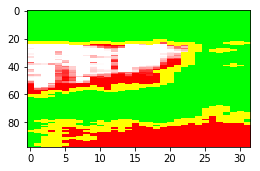

In [48]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(1, positive_only=False, num_features=5, hide_rest=False)
fig = plt.figure(figsize=(4,12))
fig.add_subplot(1, 1, 1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), aspect=1/5)